In [6]:
import numpy as np
import matplotlib.pyplot as plt
from bisou_sky import get_sky

In [2]:
nside = 128
models = ["c1", "d2", "s1", "a1", "f1"]
frequencies = np.arange(60, 2000, 15)
fwhm_deg = 1.0

m = get_sky(
    frequencies,
    nside,
    models=models,
    fwhm_deg=1.0,
    maps_coord="G",
)
m.shape # (130, 196608)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(130, 196608)

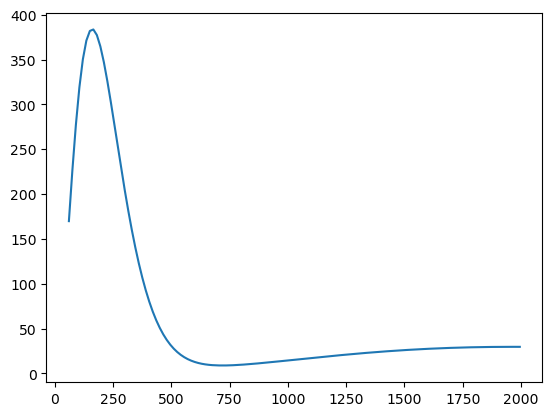

In [7]:
plt.plot(frequencies,m.mean(axis=1))

Calculating components...
... Loading masks from HFI_Mask_GalPlane-apo0_0064_R2.00.fits


/var/folders/tm/8fyctf3n75z5vz3v82b9mym80000gn/T/ipykernel_20970/350198518.py:60: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mask_20 = hp.read_map(MASK_FILE, field=0, verbose=False)
/var/folders/tm/8fyctf3n75z5vz3v82b9mym80000gn/T/ipykernel_20970/350198518.py:61: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  mask_80 = hp.read_map(MASK_FILE, field=4, verbose=False)


Plotting...


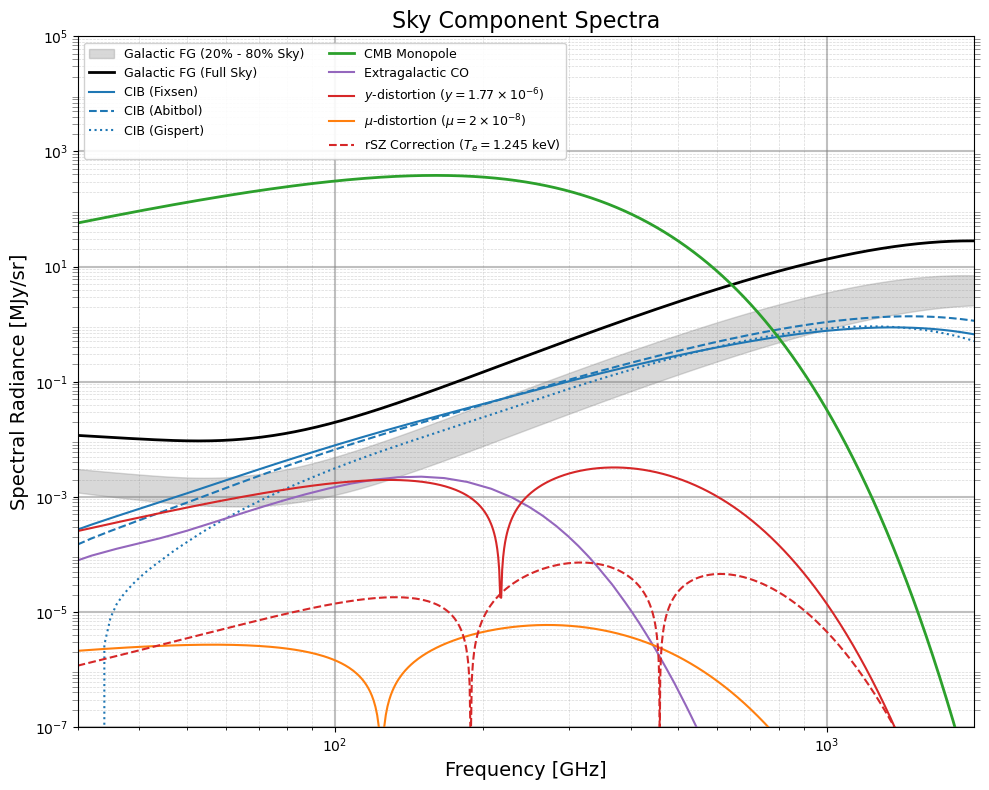

Done. Saved as components_spectrum.png


In [11]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from bisou_sky.generate_sky import (
    get_sky,
    planck,
    extragalactic_CO,
    deltaI_y_distortions,
    deltaI_mu_distortions,
    deltaI_y_distortions_relativistic_corrections,
    T_CMB_K
)

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
FREQUENCIES = np.arange(30, 2000, 1)  
NSIDE = 64  

PARAMS = {
    "y_distortions": 1.77e-6,
    "mu_distortions": 2e-8,
    "t_e_sz": 1.245,
    "A_eg_CO": 1.0
}

MASK_FILE = "HFI_Mask_GalPlane-apo0_0064_R2.00.fits"

# -----------------------------------------------------------------------------
# 1. GENERATE MAPS & SPECTRA
# -----------------------------------------------------------------------------
print("Calculating components...")

# --- Foregrounds (Low Complexity) ---
m_fg = get_sky(
    freqs=FREQUENCIES,
    nside=NSIDE,
    models=["a1", "f1", "d1", "s1"], 
    fwhm_deg=0.0, 
    add_cmb_monopole_and_dipole=False,
    add_cib_monopole_and_dipole=False,
    y_distortions=0.0,
    mu_distortions=0.0,
    A_eg_CO=0.0,
    maps_coord="G"
)
fg_spectrum_full = np.mean(m_fg, axis=1)

# --- Apply Masks for Shaded Region (20% - 80%) ---
fg_spectrum_20 = None
fg_spectrum_80 = None

if os.path.exists(MASK_FILE):
    print(f"... Loading masks from {MASK_FILE}")
    # Index 0 corresponds to ~0.20
    # Index 4 corresponds to ~0.80
    
    mask_20 = hp.read_map(MASK_FILE, field=0, verbose=False) 
    mask_80 = hp.read_map(MASK_FILE, field=4, verbose=False)
    
    def get_masked_spectrum(maps, mask):
        mask_sum = np.sum(mask)
        if mask_sum == 0: return np.zeros(maps.shape[0])
        return np.dot(maps, mask) / mask_sum

    fg_spectrum_20 = get_masked_spectrum(m_fg, mask_20)
    fg_spectrum_80 = get_masked_spectrum(m_fg, mask_80)
else:
    print(f"WARNING: Mask file {MASK_FILE} not found. Using fallback.")
    fg_spectrum_20 = fg_spectrum_full * 0.5
    fg_spectrum_80 = fg_spectrum_full * 1.5

# --- CIB Models ---
cib_spectra = {}
for model in ["fixsen", "abitbol", "gispert"]:
    m_cib = get_sky(
        freqs=FREQUENCIES,
        nside=NSIDE,
        models=[],
        add_cmb_monopole_and_dipole=False,
        add_cib_monopole_and_dipole=True,
        cib_model=model,
        maps_coord="G"
    )
    cib_spectra[model] = np.mean(m_cib, axis=1)

# --- Analytical Components ---
cmb_spectrum = planck(FREQUENCIES, T_CMB_K)
co_spectrum = extragalactic_CO(FREQUENCIES, PARAMS["A_eg_CO"])
y_spectrum = deltaI_y_distortions(FREQUENCIES, PARAMS["y_distortions"], T_CMB_K)
mu_spectrum = deltaI_mu_distortions(FREQUENCIES, PARAMS["mu_distortions"], T_CMB_K)
rsz_spectrum = deltaI_y_distortions_relativistic_corrections(
    FREQUENCIES, PARAMS["y_distortions"], PARAMS["t_e_sz"], T_CMB_K
)

# -----------------------------------------------------------------------------
# 2. PLOTTING
# -----------------------------------------------------------------------------
print("Plotting...")

fig, ax = plt.subplots(figsize=(10, 8))

# -- Foregrounds Shaded Region --
if fg_spectrum_20 is not None:
    ax.fill_between(
        FREQUENCIES, 
        fg_spectrum_20, 
        fg_spectrum_80, 
        color='gray', 
        alpha=0.3, 
        label='Galactic FG (20% - 80% Sky)'
    )

# -- Lines --
ax.plot(FREQUENCIES, fg_spectrum_full, 'k', lw=2, label='Galactic FG (Full Sky)')
ax.plot(FREQUENCIES, cib_spectra['fixsen'], 'tab:blue', ls='-', label='CIB (Fixsen)')
ax.plot(FREQUENCIES, cib_spectra['abitbol'], 'tab:blue', ls='--', label='CIB (Abitbol)')
ax.plot(FREQUENCIES, cib_spectra['gispert'], 'tab:blue', ls=':', label='CIB (Gispert)')
ax.plot(FREQUENCIES, cmb_spectrum, 'tab:green', lw=2, label='CMB Monopole')
ax.plot(FREQUENCIES, co_spectrum, 'tab:purple', ls='-', label='Extragalactic CO')
ax.plot(FREQUENCIES, np.abs(y_spectrum), 'tab:red', ls='-', label=r'$y$-distortion ($y=1.77 \times 10^{-6}$)')
ax.plot(FREQUENCIES, np.abs(mu_spectrum), 'tab:orange', ls='-', label=r'$\mu$-distortion ($\mu=2 \times 10^{-8}$)')
ax.plot(FREQUENCIES, np.abs(rsz_spectrum), 'tab:red', ls='--', label=r'rSZ Correction ($T_e=1.245$ keV)')

# -- Scales and Limits --
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(FREQUENCIES.min(), FREQUENCIES.max())
ax.set_ylim(1e-7, 1e5)

# -- Labels --
ax.set_xlabel('Frequency [GHz]', fontsize=14)
ax.set_ylabel('Spectral Radiance [MJy/sr]', fontsize=14)
ax.set_title('Sky Component Spectra', fontsize=16)

# -- FORCING MINOR TICKS --
ax.grid(which='major', linestyle='-', linewidth=1.5, color='gray', alpha=0.5)
# Set ticks at 2, 3, ..., 9 for every decade
minor_locator = LogLocator(base=10.0, subs=np.arange(2, 10) * 1.0, numticks=100)
ax.yaxis.set_minor_locator(minor_locator)
ax.tick_params(axis='y', which='minor', length=4, color='gray', left=True, right=True)
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Legend
ax.legend(loc='upper left', fontsize=9, framealpha=0.9, ncol=2)

plt.tight_layout()
plt.savefig("components_spectrum.png", dpi=300)
plt.show()

print("Done. Saved as components_spectrum.png")